In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os, sys
import scipy.integrate as spi

CURRENT_DIR = os.getcwd()
module_path = os.path.abspath(os.path.join(CURRENT_DIR, "../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
from Anydim_transferability.DeepSet.model import DeepSet
from Anydim_transferability.DeepSet import color_dict
from Anydim_transferability import typesetting

typesetting()

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_samples = 100
log_n_range = np.arange(1, 4.1, 0.3)
torch.manual_seed(50)
# fix input distribution
gaussian = torch.distributions.Normal(loc=0.0, scale=1.0)

# fix 3 models with random weights
deepset = DeepSet(in_channels=1, output_channels=1, hidden_dim=128, normalization=None)
normalized_deepset = DeepSet(in_channels=1, output_channels=1, hidden_dim=128, normalization="mean")
pointnet = DeepSet(in_channels=1, output_channels=1, hidden_dim=128, normalization="max")
deepset.eval()
normalized_deepset.eval()
pointnet.eval()

# compute output
n_range = np.power(10, log_n_range).astype(int)
models = {
    "DeepSet": deepset,
    "Normalized DeepSet": normalized_deepset,
    "PointNet": pointnet,
}
outputs = {}
for model_name, model in models.items():
    outputs.setdefault(model_name, [])
    for i, n in enumerate(n_range):
        X = gaussian.sample((n_samples, n)).unsqueeze(-1)
        with torch.no_grad():
            output = model(X)
            outputs[model_name].append(output)


def deepset_limit(model):
    def integrand(x):
        with torch.no_grad():
            output = (
                model.feature_extractor(torch.Tensor([x]).reshape(-1, 1, 1))
                .squeeze()
                .detach()
                .numpy()
            )
        pdf = np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi)
        return output * pdf

    # Integrate each component of the vector separately
    result = []
    for i in range(50):  # multi-dimensional integration over the set-channel=50
        component_integrand = lambda x: integrand(x)[i]
        integral, _ = spi.quad(component_integrand, -np.inf, np.inf, limit=500)
        result.append(integral)
    result = np.array(result)

    return float(model.regressor(torch.Tensor(result).reshape(1, 1, -1)))


limit = deepset_limit(normalized_deepset)

/tmp/ipykernel_223048/4258778649.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = spi.quad(component_integrand, -np.inf, np.inf, limit=500)


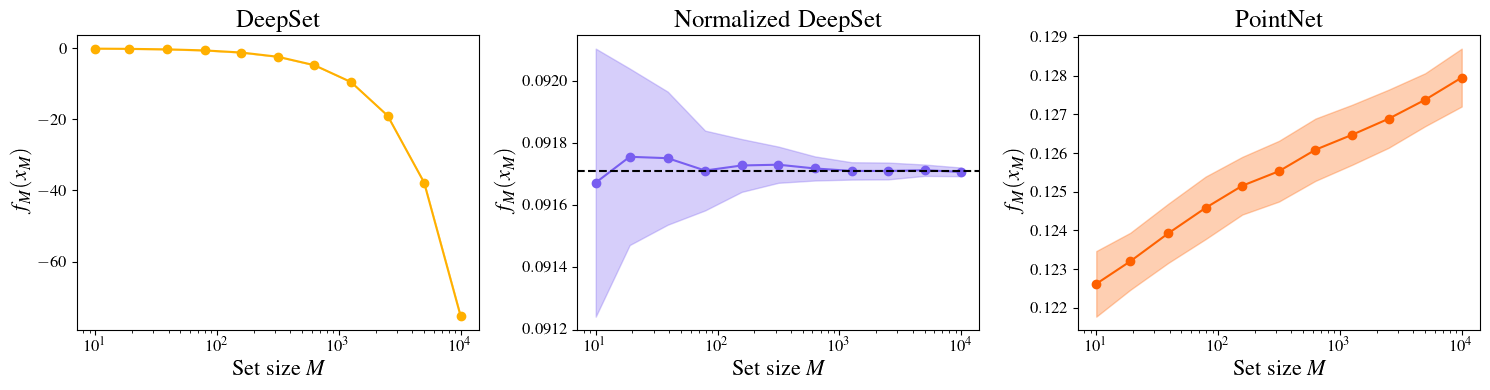

In [3]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, (model_name, color) in zip(axs, color_dict.items()):
    # ax.errorbar(
    #     n_range,
    #     [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
    #     [float(outputs[model_name][i].std(dim=0).squeeze()) for i in range(len(n_range))],
    #     fmt="o",
    #     capsize=3,
    #     markersize=5,
    #     color=color,
    # )
    ax.plot(
        n_range,
        [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        "o-",
        color=color,
    )
    ax.fill_between(
        n_range,
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            - float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            + float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        color=color,
        alpha=0.3,
    )
    if model_name == "Normalized DeepSet":
        ax.axhline(limit, color="k", linestyle="--", label="Limit")
    ax.set_xscale("log")
    ax.set_xlabel(r"Set size $M$", fontsize=16)
    ax.set_ylabel(r"$f_M(x_M)$", fontsize=16)
    ax.set_title(model_name, fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=12)

plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/deepset_transferability_outputs.pdf")
plt.show()

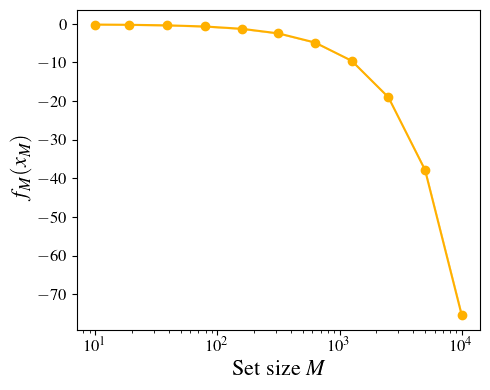

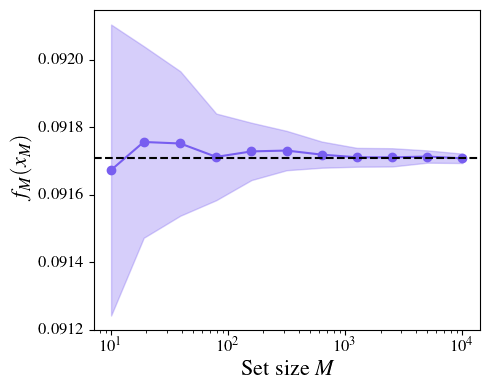

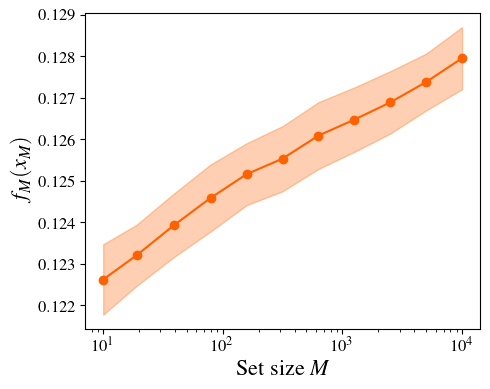

In [4]:
# plot
for model_name, color in color_dict.items():
    plt.figure(figsize=(5, 4))
    plt.plot(
        n_range,
        [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        "o-",
        color=color,
    )
    plt.fill_between(
        n_range,
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            - float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            + float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        color=color,
        alpha=0.3,
    )
    if model_name == "Normalized DeepSet":
        plt.axhline(limit, color="k", linestyle="--", label="Limit")
    plt.xscale("log")
    plt.xlabel(r"Set size $M$", fontsize=16)
    plt.ylabel(r"$f_M(x_M)$", fontsize=16)
    plt.tick_params(axis="both", which="major", labelsize=12)
    plt.tight_layout()
    plt.savefig(
        CURRENT_DIR
        + f"/log/transferability/{model_name.lower().replace(' ', '_')}_transferability_outputs.pdf"
    )
    plt.show()

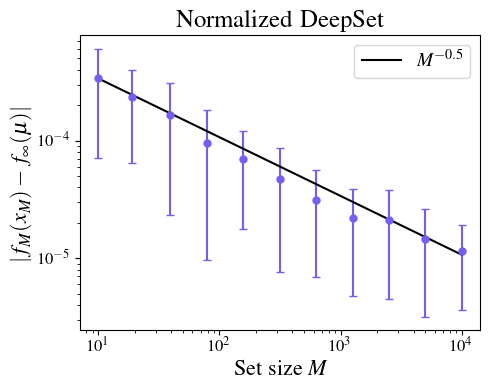

In [5]:
errors = [torch.abs(outputs["Normalized DeepSet"][i] - limit) for i in range(len(n_range))]
plt.figure(figsize=(5, 4))
plt.errorbar(
    n_range,
    [float(errors[i].mean(dim=0).squeeze()) for i in range(len(n_range))],
    [float(errors[i].std(dim=0).squeeze()) for i in range(len(n_range))],
    fmt="o",
    capsize=3,
    markersize=5,
    color=color_dict["Normalized DeepSet"],
)
# plt.plot(
#     n_range,
#     [float(errors[i].mean(dim=0).squeeze()) for i in range(len(n_range))],
#     "o-",
#     color=color_dict["Normalized DeepSet"],
# )
# plt.fill_between(
#     n_range,
#     [
#         float(errors[i].mean(dim=0).squeeze()) - float(errors[i].std(dim=0).squeeze())
#         for i in range(len(n_range))
#     ],
#     [
#         float(errors[i].mean(dim=0).squeeze()) + float(errors[i].std(dim=0).squeeze())
#         for i in range(len(n_range))
#     ],
#     color=color_dict["Normalized DeepSet"],
#     alpha=0.3,
# )
reference = n_range ** (-0.5) * n_range[0] ** (0.5) * float(errors[0].mean(dim=0).squeeze())
plt.title("Normalized DeepSet", fontsize=18)
plt.plot(n_range, reference, label=r"$M^{-0.5}$", color="black")
plt.xlabel("Set size $M$", fontsize=16)
plt.ylabel(r"$|f_M(x_M) - f_\infty(\mu)|$", fontsize=16)
plt.legend(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/deepset_transferability_errors.pdf")
plt.show()